In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
DATA_DIR = 'data/'

all_xray_df = pd.read_csv(f'{DATA_DIR}Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(30)


Scans found: 0 , Total Headers 112120


Image Index                                    Finding Labels  \
38239   00010007_158.png                     Atelectasis|Effusion|Fibrosis   
66931   00016545_000.png                                        No Finding   
75006   00018388_004.png                                        No Finding   
111353  00030424_000.png                                        No Finding   
15860   00004189_000.png                                        No Finding   
96200   00025303_025.png            Atelectasis|Consolidation|Pneumothorax   
77381   00019009_000.png                                        No Finding   
15908   00004205_009.png                                        No Finding   
110054  00029943_035.png                                     Consolidation   
97974   00025849_018.png                                        No Finding   
1907    00000494_003.png                                        No Finding   
23958   00006304_042.png                                        No Finding   
44602   00011460_076.png                                Pleural_Thickening   
35506   00009361_010.png                                        No Finding   
38302   00010012_024.png                      Edema|Infiltration|Pneumonia   
102023  00027153_001.png                                        No Finding   
69191   00017076_000.png                                      Infiltration   
96249   00025317_004.png                                      Infiltration   
9181    00002395_031.png                      Effusion|Infiltration|Nodule   
65983   00016293_001.png                                        No Finding   
1427    00000372_005.png                 Atelectasis|Effusion|Infiltration   
78878   00019363_042.png  Cardiomegaly|Consolidation|Effusion|Infiltration   
5282    00001404_000.png                                            Nodule   
41477   00010722_007.png                                        No Finding   
14873   00003880_002.png                                        No Finding   
71719   00017666_002.png                                        No Finding   
9144    00002390_003.png                Atelectasis|Consolidation|Effusion   
16154   00004325_000.png                                        No Finding   
7400    00001951_001.png                                 Mass|Pneumothorax   
88168   00021817_001.png                                        No Finding   

        Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
38239           158       10007           59              M            AP   
66931             0       16545           50              F            PA   
75006             4       18388           74              M            PA   
111353            0       30424           28              M            PA   
15860             0        4189           64              F            PA   
96200            25       25303           67              F            PA   
77381             0       19009           51              F            PA   
15908             9        4205           48              M            PA   
110054           35       29943           65              F            AP   
97974            18       25849           58              M            AP   
1907              3         494           64              F            PA   
23958            42        6304           67              F            AP   
44602            76       11460           17              M            PA   
35506            10        9361           53              M            PA   
38302            24       10012           53              M            AP   
102023            1       27153           23              M            PA   
69191             0       17076           34              F            PA   
96249             4       25317           53              F            AP   
9181             31        2395           62              F            AP   
65983             1       16293           42          

## EDA

### 1. Diseases distribution

Find the proportion of the images with pneumonia/without pneumonia.

In [3]:
all_xray_df = all_xray_df.rename(columns = {'Image Index' : 'image_index', 'Finding Labels': 'finding_labels',
                             'Follow-up #':'follow_up', 'Patient ID': 'patient_id', 'Patient Age':'patient_age',
                             'Patient Gender':'patient_gender', 'View Position':'view_position', 
                              'OriginalImage[Width':'orig_img_width', 'Height]':'orig_img_height',
                             'OriginalImagePixelSpacing[x':'pixel_spacing', 'Unnamed: 11':'unnamed_11'})

In [4]:
all_xray_df.loc[all_xray_df['finding_labels'].str.contains('Pneumonia')].shape[0]

1431

In [5]:
all_xray_df[all_xray_df['finding_labels'].str.contains('Pneumonia')].shape[0]/all_xray_df.shape[0]

0.012763110952550838

Only 1% of the total images have diagnosed pneumonia.
That means that we'll need to discard most of the images while training

Now, show the distribution of all 14 diseases 

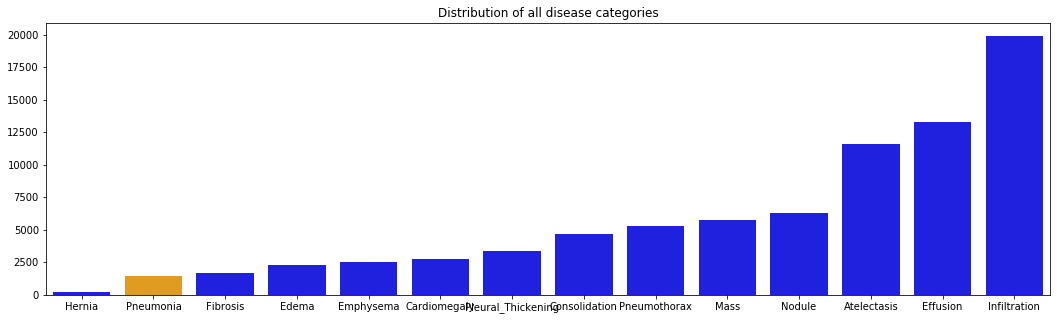

In [6]:
diseases = np.array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 
            'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'])
diseases_counts = []

for disease in diseases:
    diseases_counts.append(all_xray_df[all_xray_df['finding_labels'].str.contains(disease)].shape[0])
diseases_counts = np.array(diseases_counts)
diseases = diseases[diseases_counts.argsort()]
diseases_counts.sort()

pal = ['blue' if x != 'Pneumonia' else 'orange' for x in diseases]

plt.figure(figsize=(18,5))
plt.title('Distribution of all disease categories')# (any type of disease presence)')
sns.barplot(diseases, diseases_counts, palette=pal);

Now, let's check the distribution for primary deseases

In [7]:
new = all_xray_df["finding_labels"].str.split('|', n=1, expand=True)
all_xray_df['disease'] = new[0]
all_xray_df['comorbidity'] = new[1]

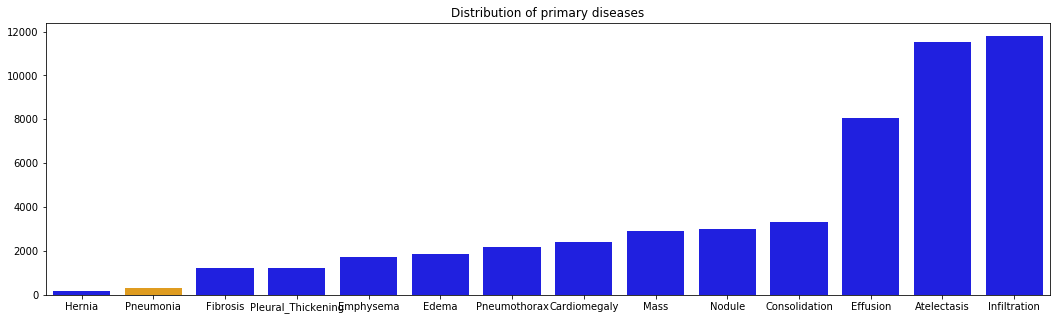

In [8]:
diseases = np.array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 
            'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'])
diseases_counts = []

for disease in diseases:
    diseases_counts.append(all_xray_df[all_xray_df['disease'].str.contains(disease)].shape[0])
diseases_counts = np.array(diseases_counts)
diseases = diseases[diseases_counts.argsort()]
diseases_counts.sort()

pal = ['blue' if x != 'Pneumonia' else 'orange' for x in diseases]

plt.figure(figsize=(18,5))
plt.title('Distribution of primary diseases')
sns.barplot(diseases, diseases_counts, palette=pal);

In [9]:
all_xray_df.comorbidity.fillna(value='No Finding', inplace=True)

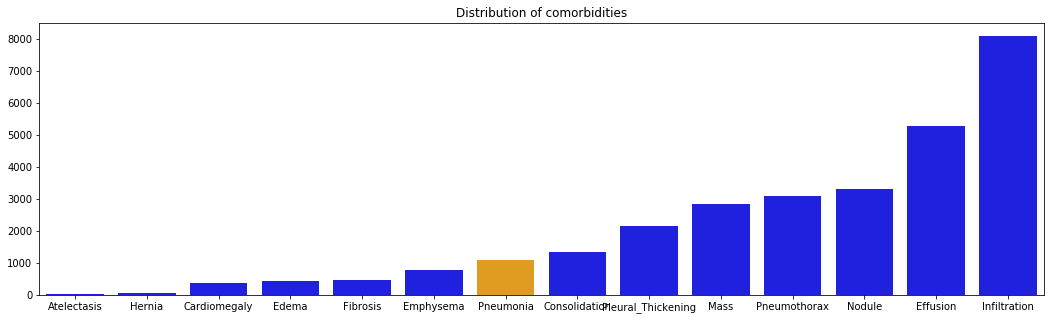

In [10]:
diseases = np.array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 
            'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'])
diseases_counts = []

for disease in diseases:
    diseases_counts.append(all_xray_df[all_xray_df['comorbidity'].str.contains(disease)].shape[0])
diseases_counts = np.array(diseases_counts)
diseases = diseases[diseases_counts.argsort()]
diseases_counts.sort()

pal = ['blue' if x != 'Pneumonia' else 'orange' for x in diseases]

plt.figure(figsize=(18,5))
plt.title('Distribution of comorbidities')
sns.barplot(diseases, diseases_counts, palette=pal);

As we can see from this plot, Pneumonia is mostly a comorbidity. So it will be important to check if there is a pneumonia as a comorbidity before discarding a sample while pre-processing the dataset for training.

### 2. Demographics

#### Age distribution

In [11]:
all_xray_df.patient_age.max()

414

In [12]:
all_xray_df.loc[all_xray_df['patient_age'] > 120, 'patient_age'] = all_xray_df[all_xray_df['patient_age'] > 120]['patient_age'].map(lambda x: x/10).max()

In [13]:
all_xray_df.patient_age.max()

95.0

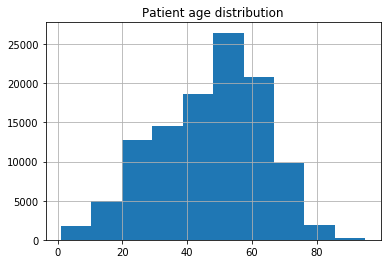

In [14]:
ax = all_xray_df.patient_age.hist()
ax.set_title('Patient age distribution');

Here we can see a normal distribution, it's already fine for further data processing 

#### Gender distribution

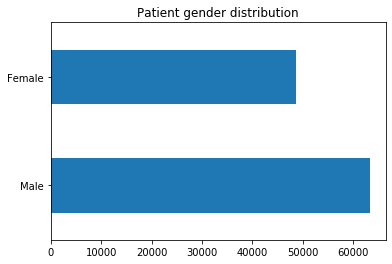

In [15]:
ax = all_xray_df.patient_gender.value_counts().plot(kind='barh')
ax.set_yticklabels(['Male', 'Female'])
ax.set_title('Patient gender distribution');

From this bar chart we can see that the difference in gender distribution is not crucial, but there are more x-rays taken from men. It will probably worth adding a bit of zooming in the data augmentation process.

### 3. Image visualizations.

Get full image paths first

In [16]:
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, 'images*', 'images', '*png'))}
all_xray_df['image_path'] = all_xray_df['image_index'].map(data_image_paths.get)
del all_xray_df['image_index']

Now plot 5 samples for every disease in the dataset 

In [17]:
# extend the labels to include no findings
all_labels = diseases.copy()
all_labels = np.append(all_labels, 'No Finding')

In [18]:
# plot 5 samples for each class
def plot_samples(column, label):
    samples = all_xray_df[all_xray_df[column] == label].sample(5)
    fig, ax = plt.subplots(1, 5, figsize=(20,4))
    ax = ax.flatten()
    fig.suptitle(label, fontsize = 20)
    for image_path, axi in zip(samples.image_path.values, ax):
        axi.set_xticks([])
        axi.set_yticks([])
        axi.imshow(plt.imread(image_path), cmap='gray')

Plot 4 classes at once to make the output visible in the notebook

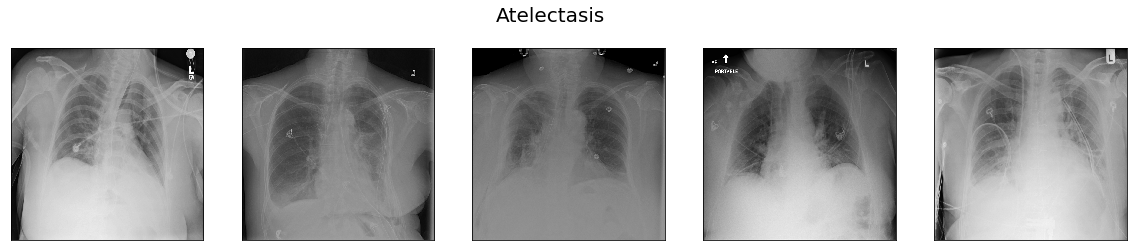

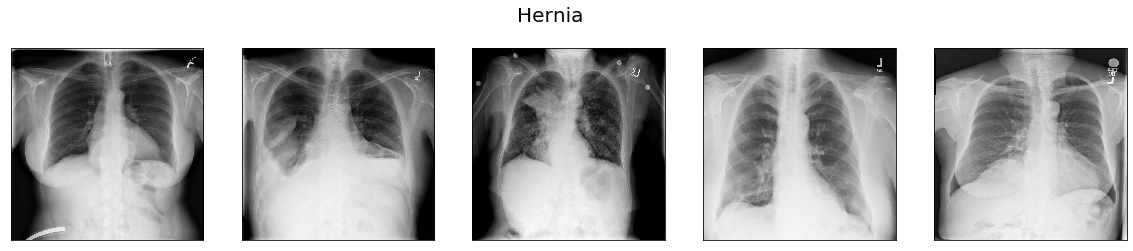

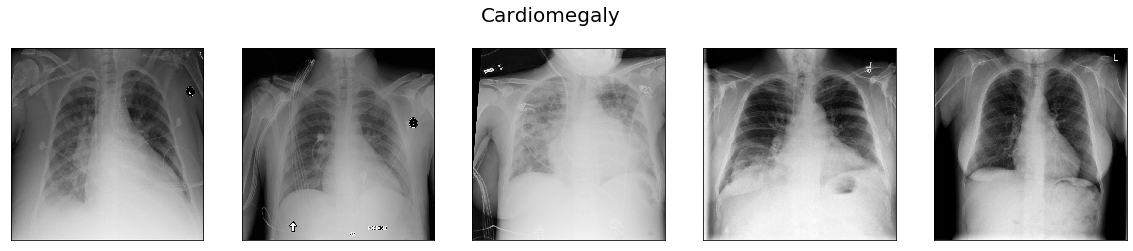

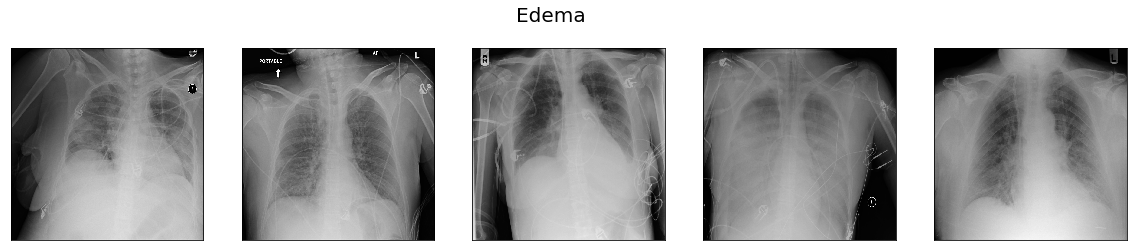

In [19]:
for label in all_labels[:4]:
    plot_samples('disease', label)

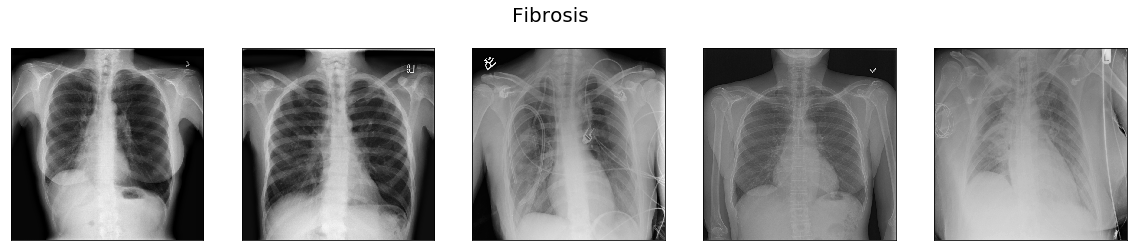

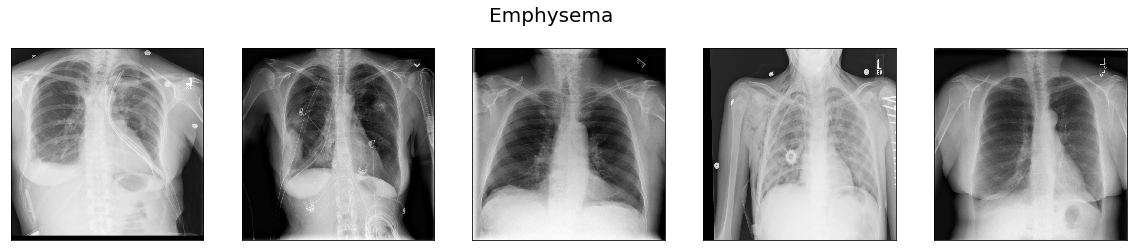

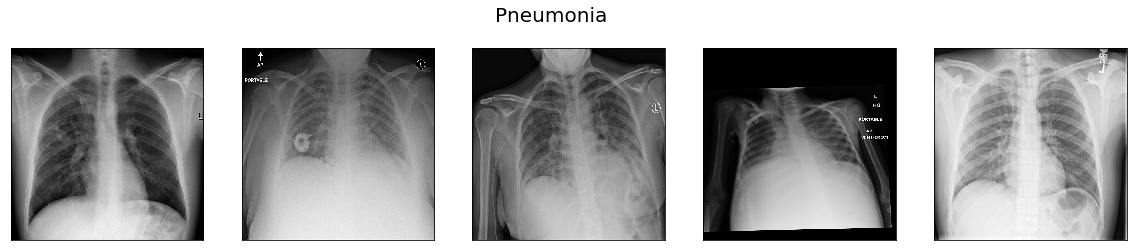

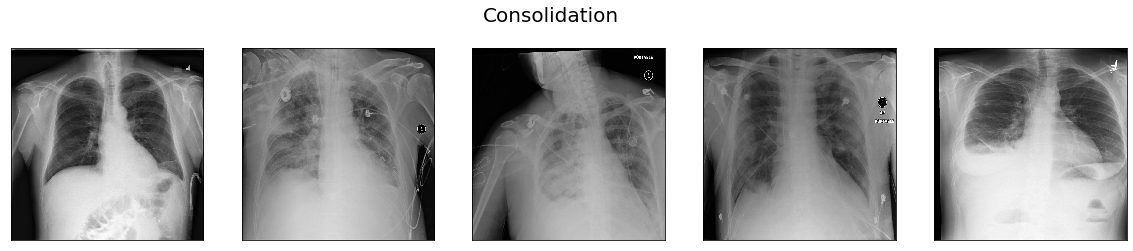

In [20]:
for label in all_labels[4:8]:
    plot_samples('disease', label)

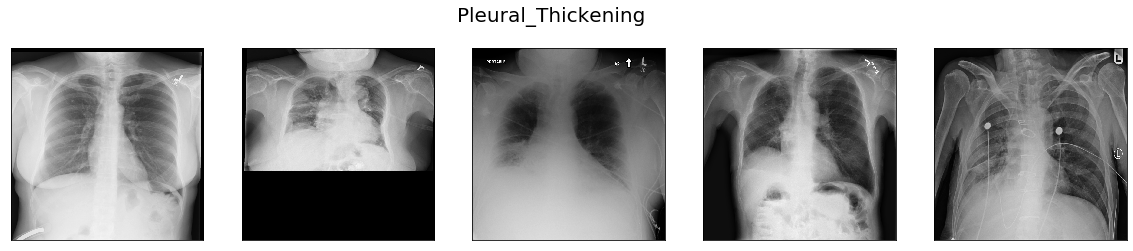

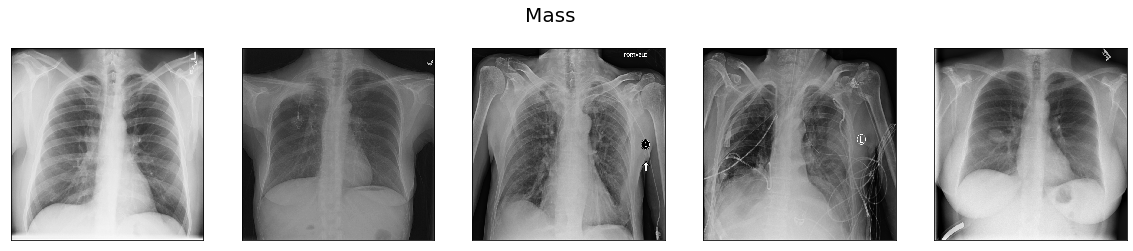

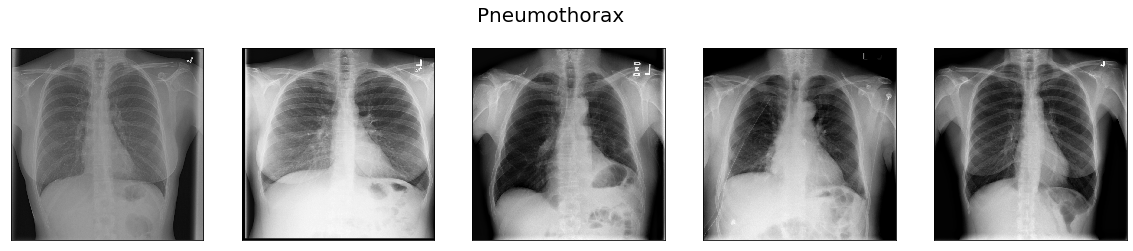

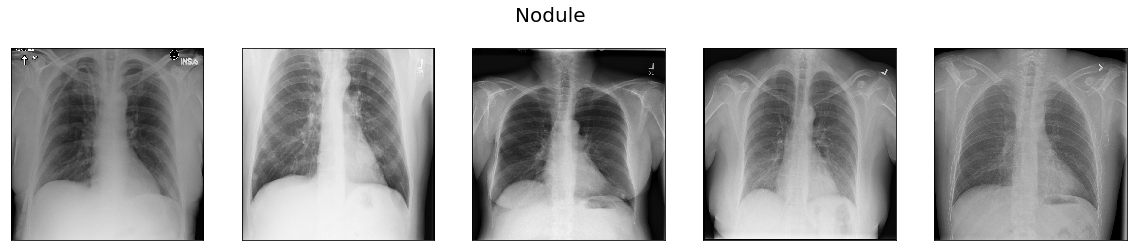

In [21]:
for label in all_labels[8:12]:
    plot_samples('disease', label)

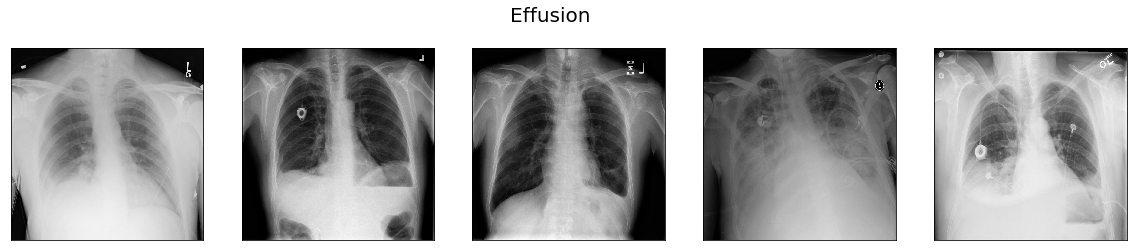

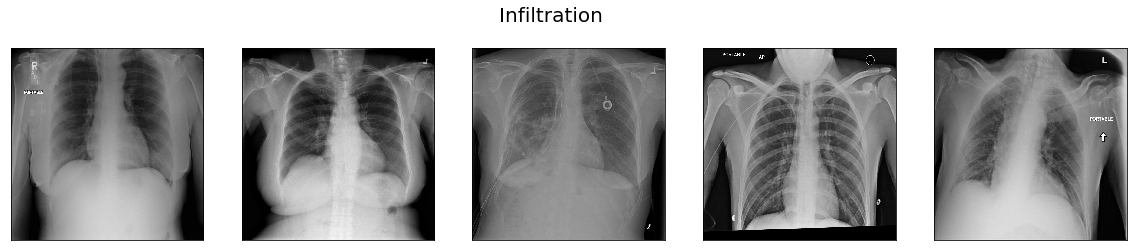

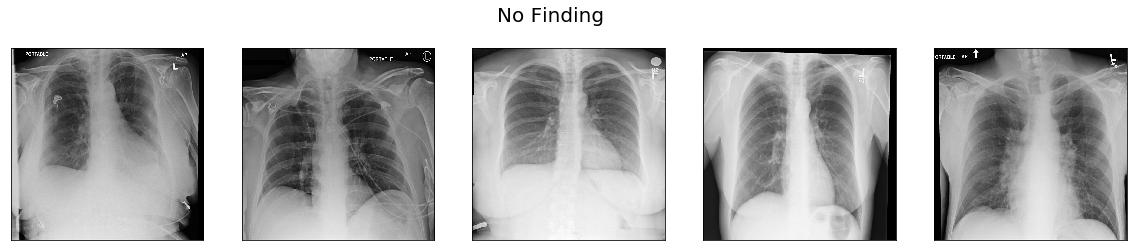

In [22]:
for label in all_labels[12:]:
    plot_samples('disease', label)

To be honest, I can't see too many differences between images with different findings. For example, Emphysema, Pneumonia and Consolidation look very similar for me (Now it makes sense why the radiologist job is hard and exhausting).
Probably, for the CNN it will be harder to correctly classify x-rays with pneumonia if there will be too many samples for Emphysema and Consolidation in the training set. So the training set should be as balanced as possible.

Now I want to explore the difference between view positions

In [23]:
all_xray_df.view_position.value_counts()

PA    67310
AP    44810
Name: view_position, dtype: int64

## Exploring different view positions:

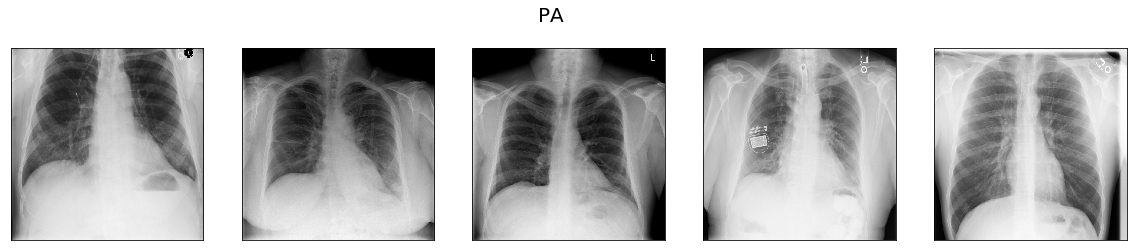

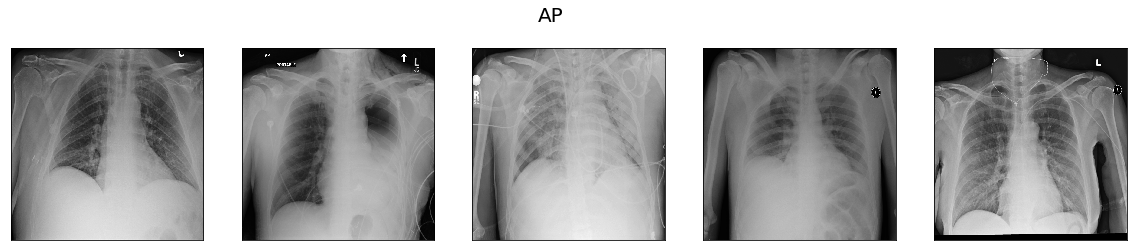

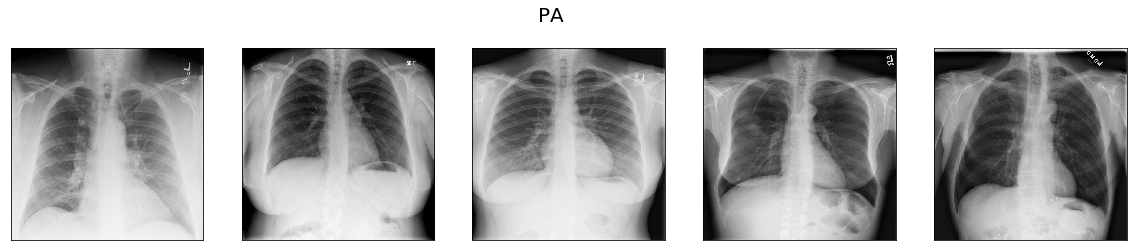

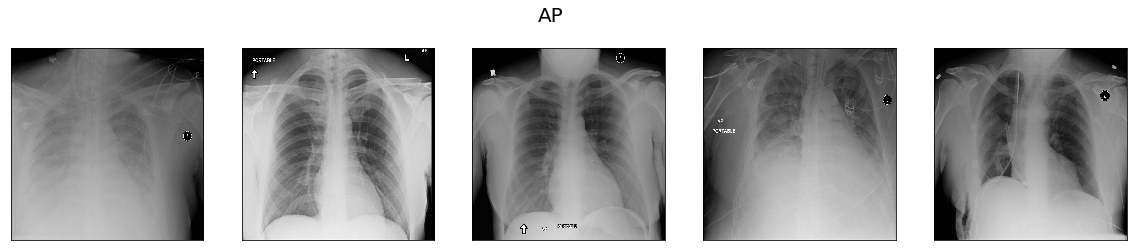

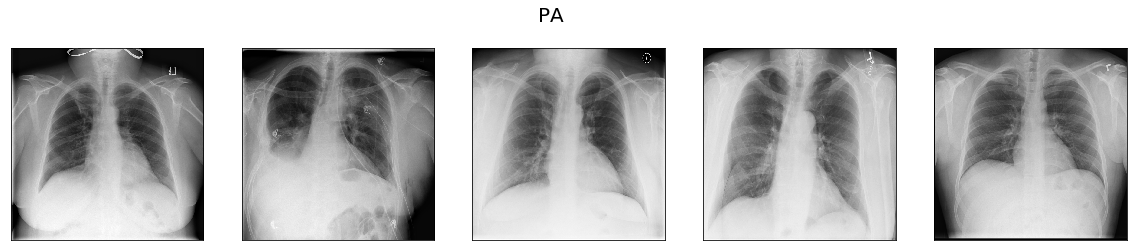

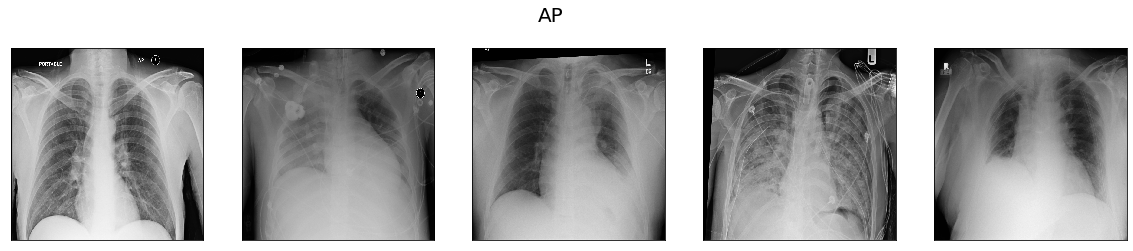

In [24]:
from IPython.display import Markdown, display
display(Markdown('## Exploring different view positions:'))
for i in range(3):
    plot_samples('view_position', 'PA')
    plot_samples('view_position', 'AP')

This parameter makes no difference for image classification.

However, I've noticed rotations on some of the x-rays. Need to add rotations in the augmentation process.

### 4. Intensity values of the pixel-level data

In [25]:
pl_df = pd.read_csv('sample_labels.csv')
pl_df

Image Index                                     Finding Labels  \
0     00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1     00000013_026.png                             Cardiomegaly|Emphysema   
2     00000017_001.png                                         No Finding   
3     00000030_001.png                                        Atelectasis   
4     00000032_001.png                        Cardiomegaly|Edema|Effusion   
...                ...                                                ...   
5601  00030712_000.png                                         No Finding   
5602  00030786_005.png                    Cardiomegaly|Effusion|Emphysema   
5603  00030789_000.png                                       Infiltration   
5604  00030792_000.png                                         No Finding   
5605  00030797_000.png                                         No Finding   

      Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0               5          13        060Y              M            AP   
1              26          13        057Y              M            AP   
2               1          17        077Y              M            AP   
3               1          30        079Y              M            PA   
4               1          32        055Y              F            AP   
...           ...         ...         ...            ...           ...   
5601            0       30712        058Y              M            PA   
5602            5       30786        061Y              F            AP   
5603            0       30789        052Y              F            PA   
5604            0       30792        010Y              F            PA   
5605            0       30797        024Y              M            PA   

      OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                   3056                 2544                     0.139000   
1                   2500                 2048                     0.168000   
2                   2500                 2048                     0.168000   
3                   2992                 2991                     0.143000   
4                   2500                 2048                     0.168000   
...                  ...                  ...                          ...   
5601                2021                 2021                     0.194311   
5602                3056                 2544                     0.139000   
5603                2021                 2021                     0.194311   
5604                1775                 1712                     0.194311   
5605                2021                 2021                     0.194311   

      OriginalImagePixelSpacing_y  
0                        0.139000  
1                        0.168000  
2                        0.168000  
3                        0.143000  
4                        0.168000  
...                           ...  
5601                     0.194311  
5602                     0.139000  
5603                     0.194311  
5604                     0.194311  
5605                     0.194311  

[5606 rows x 11 columns]